In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import tensorflow as tf
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import csv

In [3]:
#dataset
dataset_train = pd.read_csv('BERPublicsearchplus.csv', encoding = 'ISO-8859-1')

In [4]:
dataset_train = dataset_train.select_dtypes(exclude=['object'])

In [5]:
dataset_train.head()

,Year_of_Construction,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,WallArea,RoofArea,...,ThirdWallUValue,ThirdWallAgeBandId,ThirdWallTypeId,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
0,2003,231.56,94.31,0.55,0.40,0.41,1.70,3.00,85.08,94.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002,213.33,112.56,0.55,0.26,0.41,2.89,2.75,96.24,56.28,...,NaN,NaN,NaN,0.000003,0.0025,NaN,NaN,NaN,NaN,NaN
2,1980,140.55,190.88,0.40,0.32,0.59,1.90,3.00,102.47,208.07,...,0.30,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900,286.33,97.31,1.26,0.23,0.74,4.18,3.00,139.00,80.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960,579.60,76.95,1.78,0.57,0.73,4.80,1.60,80.93,160.14,...,1.78,4.0,4.0,0.002500,0.0025,NaN,NaN,NaN,NaN,NaN


In [6]:
dataset_train = dataset_train.fillna(0) 

In [7]:
dataset_train.head()

,Year_of_Construction,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,WallArea,RoofArea,...,ThirdWallUValue,ThirdWallAgeBandId,ThirdWallTypeId,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
0,2003,231.56,94.31,0.55,0.40,0.41,1.70,3.00,85.08,94.31,...,0.00,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0
1,2002,213.33,112.56,0.55,0.26,0.41,2.89,2.75,96.24,56.28,...,0.00,0.0,0.0,0.000003,0.0025,0.0,0.0,0.0,0.0,0.0
2,1980,140.55,190.88,0.40,0.32,0.59,1.90,3.00,102.47,208.07,...,0.30,6.0,5.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0
3,1900,286.33,97.31,1.26,0.23,0.74,4.18,3.00,139.00,80.95,...,0.00,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0
4,1960,579.60,76.95,1.78,0.57,0.73,4.80,1.60,80.93,160.14,...,1.78,4.0,4.0,0.002500,0.0025,0.0,0.0,0.0,0.0,0.0


In [8]:
x = dataset_train.values

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(x)

labels = kmeans.predict(x)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size = 0.30, random_state = 15)

In [11]:

scaler = MinMaxScaler()
scaler.fit(x_train)
scaler.fit(x_test)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_train_reshaped = np.reshape(x_train, (734002, 157, 1))
y_train_reshaped = np.reshape(y_train, (734002, 1))
x_test_reshaped = np.reshape(x_test, (314573, 157, 1))
y_test_reshaped = np.reshape(y_test, (314573, 1))


(734002, 157)
(734002,)
(314573, 157)
(314573,)


In [13]:
# RNN modelini oluşturma
model = Sequential()
model.add(SimpleRNN(units=64, return_sequences=True, input_shape=(157, 1)))
model.add(SimpleRNN(units=64))  # İkinci bir RNN katmanı eklendi
model.add(Dense(units=1, activation='sigmoid'))


In [14]:
# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
# Modeli eğitme
history = model.fit(x_train_reshaped, y_train_reshaped, batch_size=32, epochs=4, validation_data=(x_test_reshaped, y_test_reshaped))


Epoch 1/4
22938/22938 [==============================] - 1197s 52ms/step - loss: 0.4777 - accuracy: 0.8131 - val_loss: 0.4830 - val_accuracy: 0.8108
Epoch 2/4
22938/22938 [==============================] - 1250s 55ms/step - loss: 0.4796 - accuracy: 0.8120 - val_loss: 0.4649 - val_accuracy: 0.8183
Epoch 3/4
22938/22938 [==============================] - 1262s 55ms/step - loss: 0.4196 - accuracy: 0.8234 - val_loss: 0.4425 - val_accuracy: 0.8223
Epoch 4/4
22938/22938 [==============================] - 1244s 54ms/step - loss: 0.3467 - accuracy: 0.8482 - val_loss: 0.2934 - val_accuracy: 0.8722


In [17]:
def plot_history(history, model_name, has_metrics=False, metric_name=None, 
                 loss_metric=None):
  """Plots training and validation loss, as well as optional metric"""
  # Extract loss from the history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = np.arange(1, len(loss) + 1)

  # Create a new figure for plotting loss
  plt.figure(figsize=(12, 6))
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel('Loss' if loss_metric is not None else loss_metric, fontsize=14)
  plt.title('Training vs Validation Loss \n{}'.format('' if model_name is None else model_name), 
            fontsize=18)
  plt.legend()

  # If the user has also asked to plot a metric
  if has_metrics and metric_name is not None:
    # Create a new figure for plotting the metric
    plt.figure(figsize=(12, 6))
    metric = history.history[metric_name]
    val_metric = history.history['val_{}'.format_metric_name]
    
    plt.plot(epochs, metric, label='Training')
    plt.plot(epochs, val_metric, label='Validation')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title('Training vs Validation Loss {}'.format(metric_name), fontsize=18)
    plt.legend()

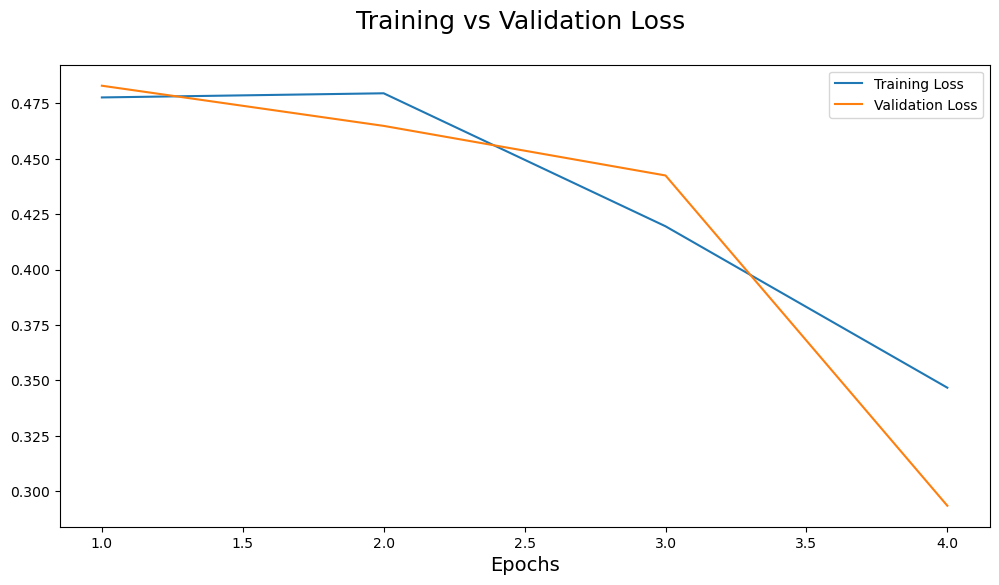

In [30]:
plot_history(history=history, 
             model_name='')

In [39]:
from sklearn.metrics import roc_curve, auc
# Tahminleri al
y_pred = model.predict(x_test_reshaped)

9831/9831 [==============================] - 156s 16ms/step


In [40]:
# ROC eğrisini çiz
fpr, tpr, thresholds = roc_curve(y_test_reshaped, y_pred)
roc_auc = auc(fpr, tpr)

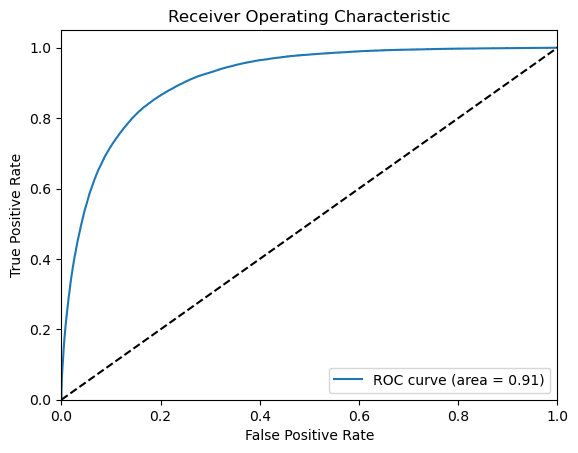

In [41]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [42]:
# Tahminleri al

y_pred = (y_pred_prob > 0.5).astype(int)



In [43]:
# Accuracy (Doğruluk) hesapla
accuracy = accuracy_score(y_test_reshaped, y_pred)
print("Accuracy: {:.2f}".format(accuracy))


Accuracy: 0.87


In [44]:
# Sınıflandırma raporunu hesapla
classification_rep = classification_report(y_test_reshaped, y_pred, labels=[0, 1], target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92    255052
     Class 1       0.66      0.67      0.67     59521

    accuracy                           0.87    314573
   macro avg       0.79      0.79      0.79    314573
weighted avg       0.87      0.87      0.87    314573



In [45]:
# Gerçek ve tahmin edilen etiketler arasında karmaşıklık matrisini hesapla
cm = confusion_matrix(y_test_reshaped, y_pred)


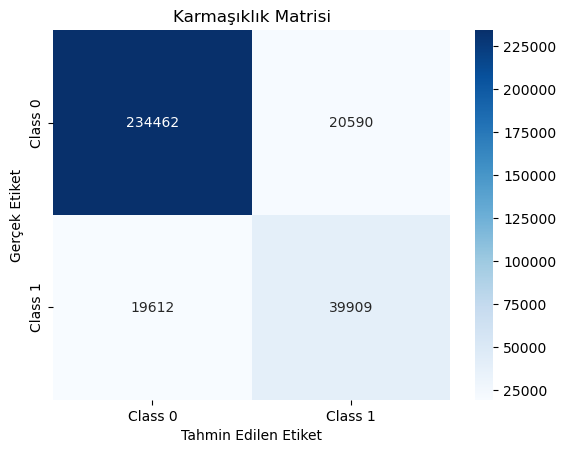

In [46]:
# Karmaşıklık matrisini görselleştir
labels = ['Class 0', 'Class 1']  # Sınıf etiketleri
sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karmaşıklık Matrisi')
plt.show()

In [130]:
import shap

# SHAP değerlerini hesaplama
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(x_test_reshaped)


AttributeError: module 'warnings' has no attribute 'DeprecationWarning'